# Analysis of PCB trials
The dataset contains mixed males and females.
The dataset also contains mixed genotypes (wt and sert-Cre hets)
* 2/15/2023 adding a new cohot with PCB given after SEFLB
* There seem to be an effect here but not sure what to make of it since the SEFLB freezing are also different.
* Trying to compare mice w/ equal amount of freezing -> this will not work bc of the high variance in SEFLB
* 6/18/2023 adding normalization with sklearn. _Summary_ so far, the standardization is not so helpful in this case, it is just augment the differences between the treatment groups.

In [1]:
!git clone https://github.com/GergelyTuri/sleep.git
%cd /content/sleep/
!pip install .

Cloning into 'sleep'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 234 (delta 121), reused 155 (delta 55), pack-reused 0
Receiving objects: 100% (234/234), 1.07 MiB | 3.80 MiB/s, done.
Resolving deltas: 100% (121/121), done.
/content/sleep
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.1-py3-none-any.whl size=997 sha256=ead8e287f1a8fbc0e99c878193676f88ae6d669d455b52cf04fa712ccb6141ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-iphvtntd/wheels/10/eb/42/5281370ac4a2d7b033087761ebaa8f968a9ef5108cbc009a46
Successfully built sleep


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
sns.set_context("talk", font_scale=0.6)

import datetime
%matplotlib inline

from sleep.base import core
from sleep.base import xcorr

In [3]:
core.mount_drive()
dr = core.GoogleDrive()
save_dir = Path('/gdrive/Shareddrives/Turi_lab/Data/PTSD_project/' \
                '!analysis/saveFolder/Psilocybin')

Mounted at /gdrive


In [4]:
raw_data = dr.load_spreadsheet_data('all_cohorts_freezing_FINAL')

In [5]:
# replacing NA to NaN
raw_data.replace('NA', np.NaN, inplace=True)
# changing `freezing` dtype to float
raw_data['freezing'] = pd.to_numeric(raw_data['freezing'],
                                        downcast='float')
# adding unique ID-s based on `id` and `cohort`
raw_data['cohort_id']= raw_data['cohort']+'_'+raw_data['id']

# TODO add DOB-s
# calculate time after SEFLA column
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1585 entries, 1 to 1585
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   freezing           1580 non-null   float32
 1   genotype           1585 non-null   object 
 2   id                 1585 non-null   object 
 3   day                1585 non-null   object 
 4   condition          1585 non-null   object 
 5   sex                1585 non-null   object 
 6   cohort             1585 non-null   object 
 7   exposure_mins      1580 non-null   object 
 8   analyzed_duration  1580 non-null   object 
 9   date               1516 non-null   object 
 10  time               1516 non-null   object 
 11  els                1585 non-null   object 
 12  psilocybin         1585 non-null   object 
 13  cohort_id          1585 non-null   object 
dtypes: float32(1), object(13)
memory usage: 167.3+ KB


### List of cohorts included in this analysis

In [6]:
cohort_list = ['ptsd2','ptsd3', 'ptsd4', 'ptsd5', 'ptsd6','ptsd8', 'ptsd9',
               'ptsd10', 'els1', 'els2', 'ptsd12', 'ptsd13', 'ptsd14',
               'ptsd15']
day_list = ['sefla','seflb','recall1', 'recall2', 'recall3',
            'recall4', 'recall5']

### All mice

### Filtering out some stuff, like ELS and genotypes other than WT

In [10]:
non_els_df = raw_data[(raw_data['els'] == 'n') \
                      & (raw_data['genotype'] == 'wt')]
# non_els_df = raw_data.query("els == 'n' & genotype == 'wt'")
exp_mice_df = non_els_df[(non_els_df['cohort'].isin(cohort_list)) &
                              (non_els_df['day'].isin(day_list))]
exp_mice_df = exp_mice_df.reset_index()
print(exp_mice_df.groupby(['condition',
                           'psilocybin', 'sex'])['cohort_id'].nunique())
print('\n')
print(exp_mice_df.groupby(['condition',
                           'psilocybin'])['cohort_id'].nunique())

condition  psilocybin  sex   
control    n           female    16
                       male      31
           y           male      10
sefl       n           female    22
                       male      42
           y           male      10
Name: cohort_id, dtype: int64


condition  psilocybin
control    n             47
           y             10
sefl       n             64
           y             10
Name: cohort_id, dtype: int64


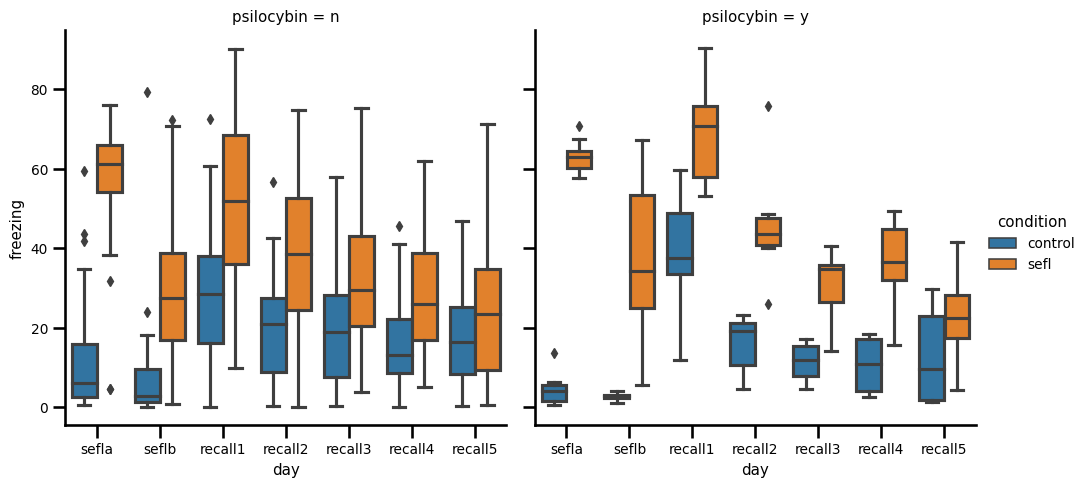

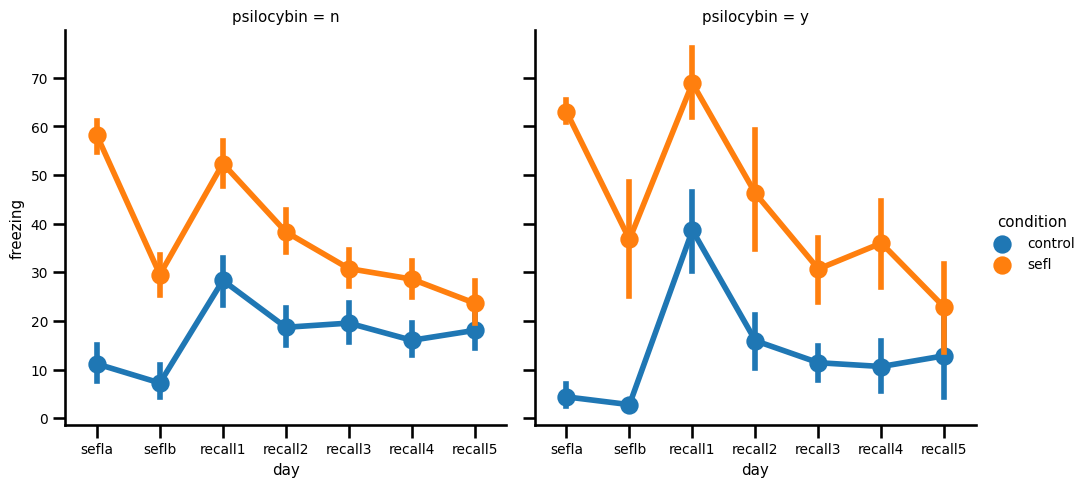

In [11]:
g = sns.catplot(data=exp_mice_df, y='freezing',
                x='day', hue='condition',
                col='psilocybin', kind='box', order=day_list)
g2 = sns.catplot(data=exp_mice_df,
                 y='freezing', x='day', hue='condition',
                col='psilocybin', kind='point', order=day_list)

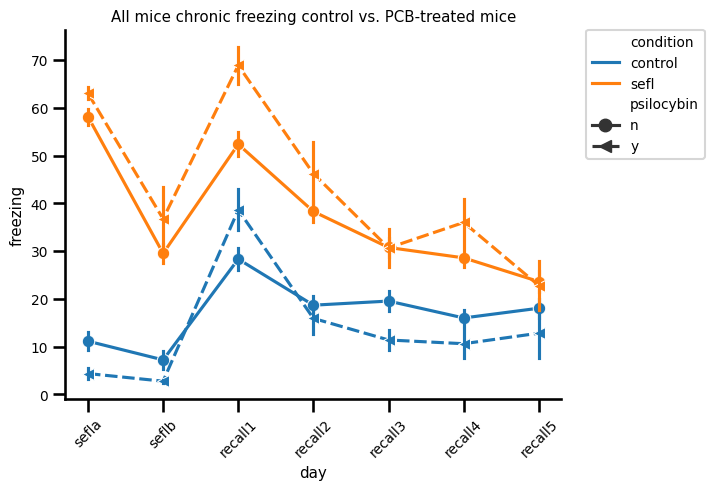

In [12]:
exp_mice_df['day'] = pd.Categorical(exp_mice_df['day'],
                                     categories=day_list,
                                     ordered=True)
g = sns.lineplot(data=exp_mice_df,
                 y='freezing', x='day', hue='condition',
                style='psilocybin', markers=['o', '<'],
                legend=True, err_style='bars', errorbar='se')
plt.title('All mice chronic freezing control vs. PCB-treated mice')
plt.setp(g.get_xticklabels(), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
# plt.savefig(save_dir.joinpath('All mice freezing.png'),
#             bbox_inches='tight', dpi=300)
plt.show()

### Standardizing data

#### Standardscaler

In [109]:
exp_mice_df.columns

Index(['index', 'freezing', 'genotype', 'id', 'day', 'condition', 'sex',
       'cohort', 'exposure_mins', 'analyzed_duration', 'date', 'time', 'els',
       'psilocybin', 'cohort_id'],
      dtype='object')

In [85]:
def scaler(data_frame: pd.DataFrame)-> pd.DataFrame:
  scaler = preprocessing.StandardScaler().set_output(transform="pandas")
  return scaler.fit_transform(data_frame)

In [111]:
sefl_data = exp_mice_df[exp_mice_df['condition']== 'sefl'].pivot(index=['cohort_id', 'psilocybin',
                                   'condition'],
                              columns=['day'],
                              values='freezing')
ctrl_data = exp_mice_df[exp_mice_df['condition']== 'control'].pivot(index=['cohort_id', 'psilocybin',
                                   'condition'],
                              columns=['day'],
                              values='freezing')

scaled_frames = []
for df in [sefl_data, ctrl_data]:
  scaled_frames.append(scaler(df))
scaled_data = pd.concat(scaled_frames, axis=0)
# scaled_data

In [112]:
df = scaled_data.melt(var_name='day', value_name='freezing',
                      ignore_index=False)
df = df.reset_index()
# df

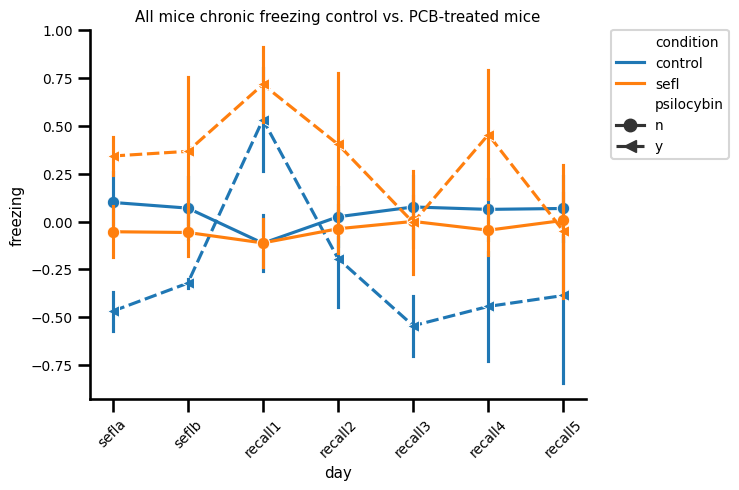

In [113]:
g = sns.lineplot(data=df,
                 y='freezing', x='day', hue='condition',
                 hue_order=['control', 'sefl'],
                style='psilocybin', markers=['o', '<'],
                legend=True, err_style='bars', errorbar='se')
plt.title('All mice chronic freezing control vs. PCB-treated mice')
plt.setp(g.get_xticklabels(), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
# plt.savefig(save_dir.joinpath('All mice freezing.png'),
#             bbox_inches='tight', dpi=300)
plt.show()

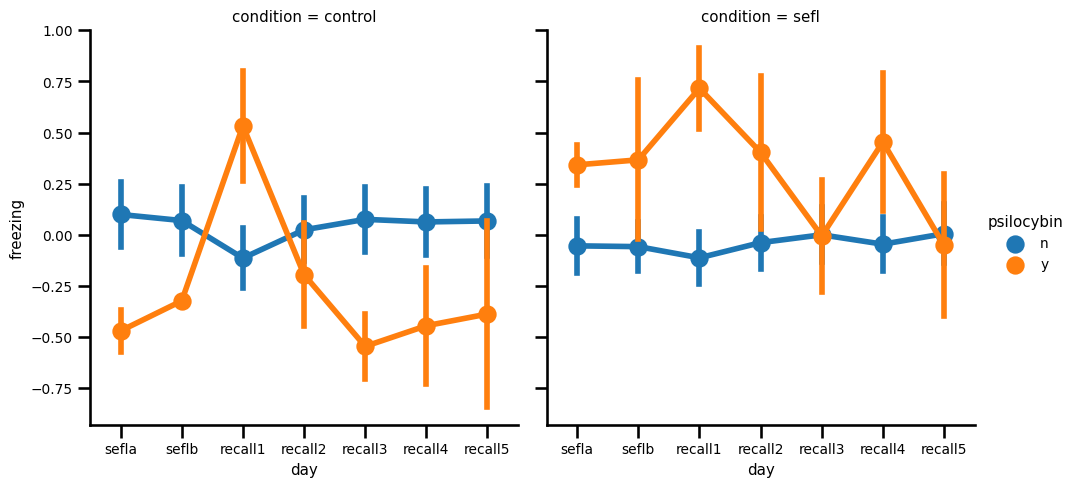

In [114]:
g = sns.catplot(data=df, y='freezing', x='day', hue='psilocybin',
                col='condition', kind='point',
                col_order=['control', 'sefl'], errorbar='se')

### Standardizing same

#### normalization
hmmm... need to get rid of the NaN-s first

In [ ]:
# norm_data = preprocessing.normalize(in_data,norm='l1')
# norm_data

## Only males

In [116]:
male_exp_mice = exp_mice_df.query("sex == 'male'")
# male_exp_mice_df = male_exp_mice[(non_els_df['cohort'].isin(cohort_list)) &
#                               (non_els_df['day'].isin(day_list))]
male_exp_mice.groupby(['condition',
                          'psilocybin', 'sex'])['cohort_id'].nunique()

condition  psilocybin  sex 
control    n           male    31
           y           male    10
sefl       n           male    42
           y           male    10
Name: cohort_id, dtype: int64

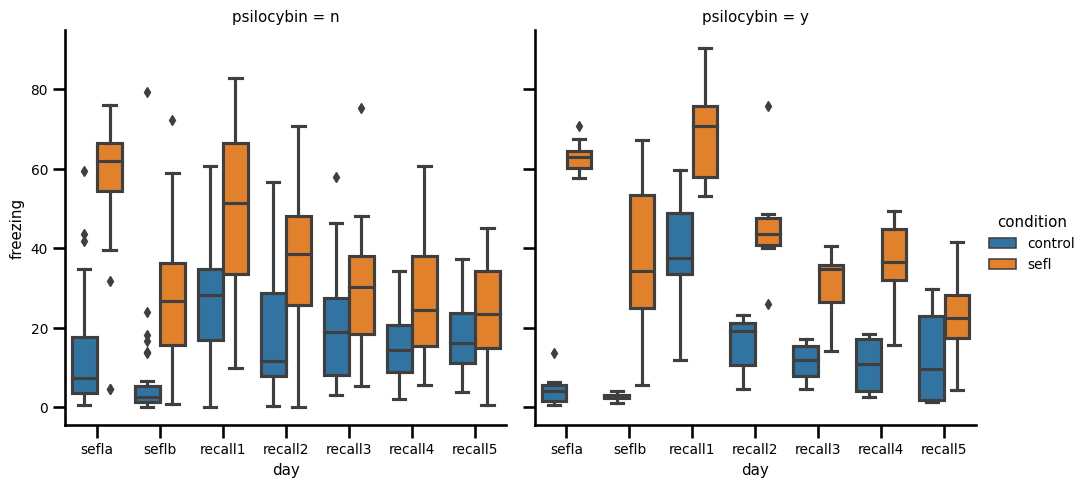

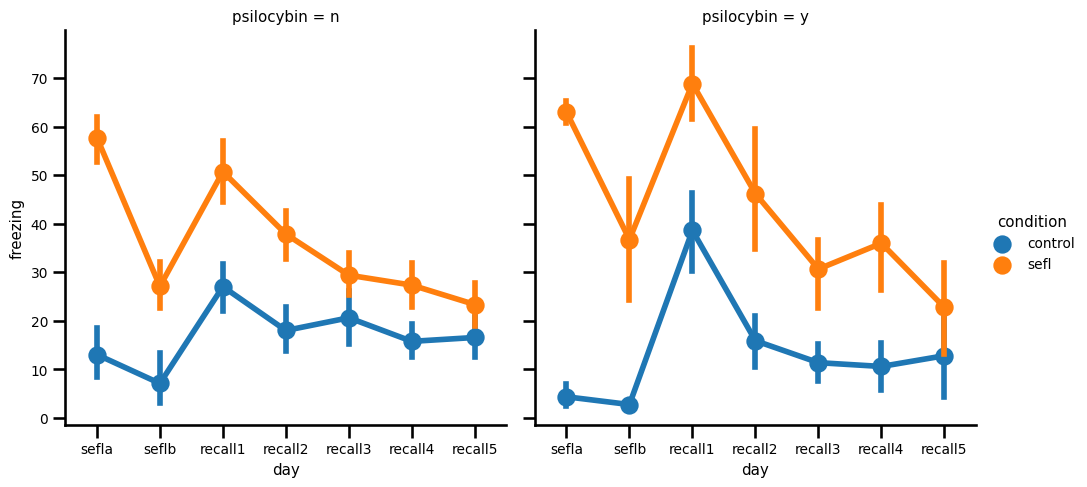

In [117]:
g = sns.catplot(data=male_exp_mice,
                y='freezing', x='day', hue='condition',
                col='psilocybin', kind='box', order=day_list)
g2 = sns.catplot(data=male_exp_mice,
                 y='freezing', x='day', hue='condition',
                col='psilocybin', kind='point', order=day_list)

<ipython-input-118-099f22ae49f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_exp_mice['day'] = pd.Categorical(male_exp_mice['day'],


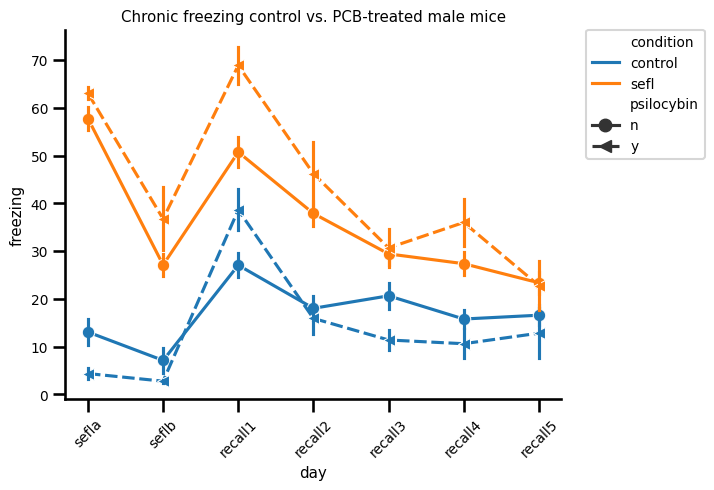

In [118]:
male_exp_mice['day'] = pd.Categorical(male_exp_mice['day'],
                                     categories=day_list,
                                     ordered=True)
g = sns.lineplot(data=male_exp_mice,
                 y='freezing', x='day', hue='condition',
                style='psilocybin', markers=['o', '<'],
                legend=True, errorbar='se', err_style='bars')
plt.title('Chronic freezing control vs. PCB-treated male mice')
plt.setp(g.get_xticklabels(), rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
# plt.savefig(save_dir.joinpath('Male mice freezing.png'),
#             bbox_inches='tight', dpi=300)

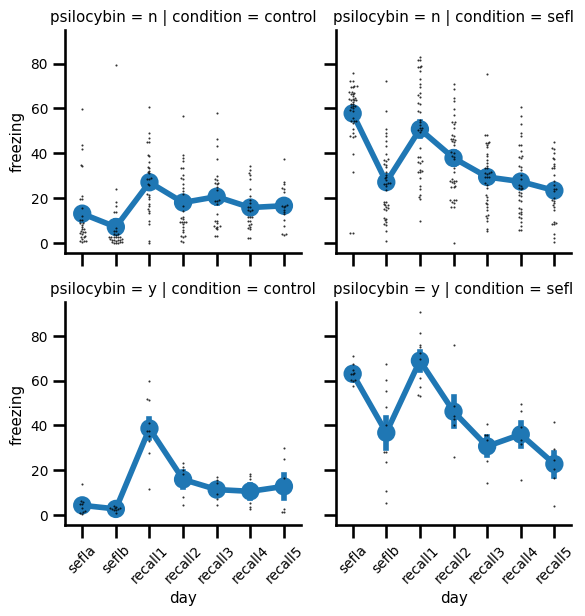

In [119]:
g = sns.FacetGrid(male_exp_mice, col='condition', row='psilocybin')
g.map(sns.pointplot, 'day','freezing', order=day_list, errorbar='se')
g.map(sns.swarmplot, 'day','freezing', alpha=.8, size=1.5, color='k',
      order=day_list)
# g.add_legend()
g.set_xticklabels(labels=day_list, rotation=45)
# g.savefig(save_dir.joinpath('Individual male mice freezing.png'),
#             bbox_inches='tight', dpi=300)

### Standardizing data

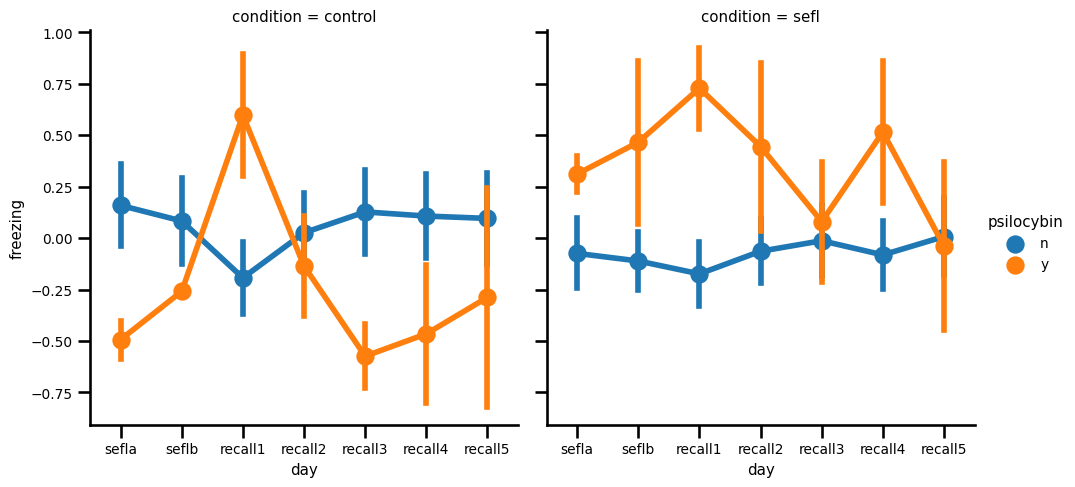

In [125]:
sefl_data = male_exp_mice[male_exp_mice['condition']== 'sefl'].pivot(
    index=['cohort_id', 'psilocybin','condition'],
                              columns=['day'],
                              values='freezing')
ctrl_data = male_exp_mice[male_exp_mice['condition']== 'control'].pivot(
    index=['cohort_id', 'psilocybin', 'condition'],
                              columns=['day'],
                              values='freezing')

scaled_frames = []
for df in [sefl_data, ctrl_data]:
  scaled_frames.append(scaler(df))
scaled_data = pd.concat(scaled_frames, axis=0)

df = scaled_data.melt(var_name='day', value_name='freezing',
                      ignore_index=False)
df = df.reset_index()

g = sns.catplot(data=df, y='freezing', x='day', hue='psilocybin',
                col='condition', kind='point',
                col_order=['control', 'sefl'], errorbar='se')

## analysis ends here for now

In [ ]:
male_xcorr = male_exp_mice_df.pivot(index=['cohort_id', 'sex', 'condition',
                                           'psilocybin'],
                                    columns="day", values="freezing")

corr = male_xcorr.groupby(['condition', 'psilocybin']).corr()
corr_ctrl = corr.iloc[corr.index.get_level_values('condition')=='control']
corr_sefl = corr.iloc[corr.index.get_level_values('condition')=='sefl']


In [ ]:
ctrl_pcb = corr_ctrl.iloc[corr_ctrl.index.get_level_values('psilocybin') == 'y']
ctrl_no_pcb = corr_ctrl.iloc[corr_ctrl.index.get_level_values('psilocybin') == 'n']
sefl_pcb = corr_sefl.iloc[corr_sefl.index.get_level_values('psilocybin') == 'y']
sefl_no_pcb = corr_sefl.iloc[corr_sefl.index.get_level_values('psilocybin') == 'n']

to_plot_dict = {'Ctrl w/ PCB': ctrl_pcb,
                'Ctrl w/o PCB': ctrl_no_pcb,
                'SEFL w/ PCB': sefl_pcb,
                'SEFL w/o PCB': sefl_no_pcb}

In [ ]:
vmin = np.min(corr.values).round(decimals=2)
vmax = np.max(corr.values).round(decimals=2)

In [ ]:
def heat_map(df: pd.DataFrame, ax: plt.axes,
             title: str, vmin: float,
             vmax: float)-> plt.axes:
  mask= np.zeros_like(df)
  mask[np.triu_indices_from(mask)] = True
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(df, cmap=cmap, center=0, square=True, linewidths=.5,
              annot=True, fmt='.2f', cbar_kws={"shrink": .5}, ax=ax, mask=mask,
              vmax=vmax, vmin=vmin, cbar=False,
              )
  ax.set_title(title)

  # yticklabels= ['recall1',
  #                                                         'recall2',
  #                                                         'recall3',
  #                                                         'recall4',
  #                                                         'recall5',
  #                                                         'sefla',
  #                                                         'seflb'],

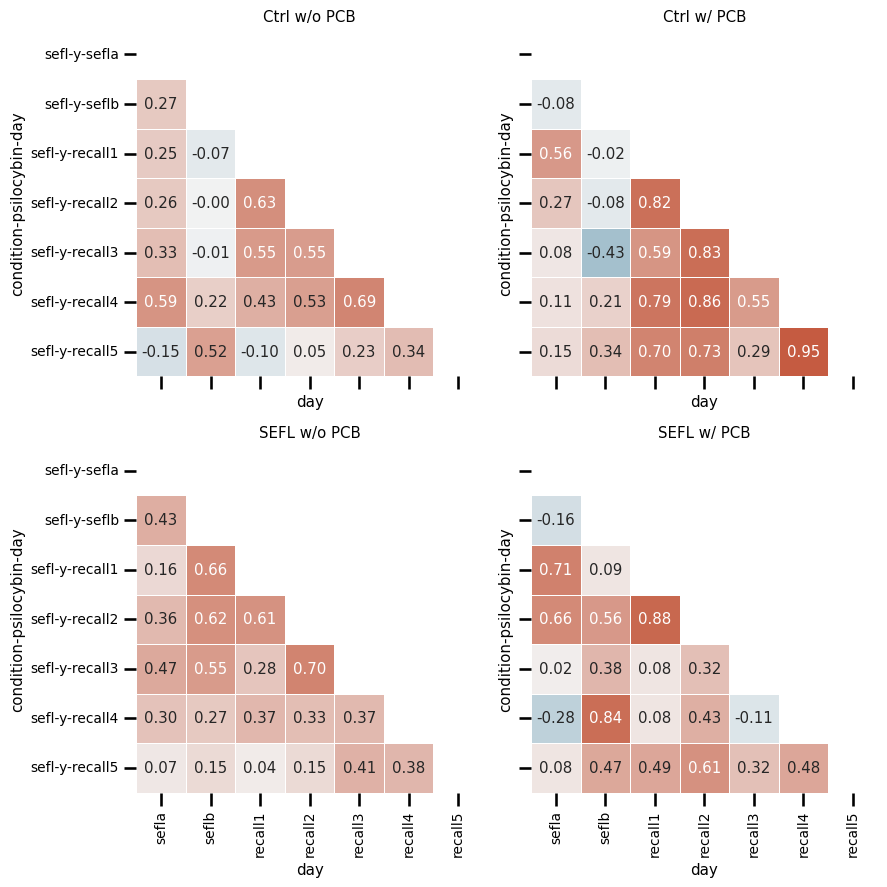

In [ ]:
f, ax = plt.subplots(figsize=(9,9), nrows=2, ncols=2, sharey=True,
                     sharex=True)

xcorr.xcorr_analysis.heat_map(to_plot_dict['Ctrl w/o PCB'], ax[0][0], 'Ctrl w/o PCB', vmin, vmax)
xcorr.xcorr_analysis.heat_map(to_plot_dict['Ctrl w/ PCB'], ax[0][1], 'Ctrl w/ PCB', vmin, vmax)
xcorr.xcorr_analysis.heat_map(to_plot_dict['SEFL w/o PCB'], ax[1][0], 'SEFL w/o PCB', vmin, vmax)
xcorr.xcorr_analysis.heat_map(to_plot_dict['SEFL w/ PCB'], ax[1][1], 'SEFL w/ PCB', vmin, vmax)
f.tight_layout()
f.savefig(save_dir.joinpath('Male xcorr plot.png'), dpi=300,
          bbox_inches='tight')
